<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [64]:
import pandas as pd
import plotly.express as px
import psycopg2
import json

In [65]:
# загрузка параметров соединения из файла
with open('sql_conection_param.json', 'r') as fp:
    con = json.load(fp)
    
connection = f'postgresql+psycopg2://{con["USER"]}:{con["PASSWORD"]}@{con["HOST"]}:{con["PORT"]}/{con["DBNAME"]}' 

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [66]:
query_3_1 = f'''
    SELECT COUNT(id) count_vacancies
    FROM public.vacancies
'''

In [67]:
df_3_1 = pd.read_sql_query(query_3_1, connection)
df_3_1

,count_vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [68]:
query_3_2 = f'''
    SELECT COUNT(id) count_employers
    FROM public.employers
'''

In [69]:
df_3_2 = pd.read_sql_query(query_3_2, connection)
df_3_2

,count_employers
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [70]:
query_3_3 = f'''
    SELECT COUNT(id) count_areas
    FROM public.areas
'''

In [71]:
df_3_3 = pd.read_sql_query(query_3_3, connection)
df_3_3

,count_areas
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [72]:
query_3_4 = f'''
    SELECT COUNT(id) count_industries
    FROM public.industries
'''

In [73]:
df_3_4 = pd.read_sql_query(query_3_4, connection)
df_3_4

,count_industries
0,294


5. Дополнительные исследования.

In [74]:
query_3_5 = f'''
    /* поскольку в PostgreeSQL с переменными дело - труба, 
    пришлось в подзапросах дублировать все предыдущие запросы, 
    чтобы получить средние показатели из общих данных */
    SELECT 
        ROUND ( -- округление до целого
            (SELECT COUNT(id) FROM public.vacancies) / -- получаем количество и делим его
            (SELECT COUNT(id) FROM public.employers)   -- на другое количество
        )::int vacancies_per_employer, -- приведение к целому
        ROUND (
            (SELECT COUNT(id) FROM public.vacancies) / 
            (SELECT COUNT(id) FROM public.areas)
        )::int vacancies_per_area,
        ROUND (
            (SELECT COUNT(id) FROM public.vacancies) / 
            (SELECT COUNT(id) FROM public.industries)
        )::int vacancies_per_industry,
        ROUND (
            (SELECT COUNT(id) FROM public.employers) / 
            (SELECT COUNT(id) FROM public.industries)
        )::int employers_per_industry,
        ROUND (
            (SELECT COUNT(id) FROM public.employers) / 
            (SELECT COUNT(id) FROM public.areas)
        )::int employers_per_area        
'''

In [75]:
df_3_5 = pd.read_sql_query(query_3_5, connection)
df_3_5

,vacancies_per_employer,vacancies_per_area,vacancies_per_industry,employers_per_industry,employers_per_area
0,2,36,167,79,17


***

### выводы по предварительному анализу данных
В базе данных:  

* вакансий 49197  
* работадателей 23501  
* регионов 1362  
* сфер деятельности 294  

Довольно большая база в массштабе одного человека, но на страну с населением в 140 000 000, это возможно не так уж и много.   
Нужно стравнивать с другими странами и отраслями.  

Если бы распределение вакансий и работадателей было равномерным по регионам и т.д. то мы бы получили такие цифры:  
 
в среднем 2 вакансии на 1 работадателя,  
в среднем 36 вакансии на 1 регион,   
в среднем 167 вакансий на 1 сферу деятельности,    
в среднем 79 работадателей на 1 сферу деятельности,    
в среднем 17 работадателей на 1 регион  

Посмотрим, как на самом деле.


# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [76]:
query_4_1 = f'''
    SELECT 
        COUNT (v.id) count_vacancies,
        a.name
    FROM 
        public.vacancies v
        JOIN public.areas a ON a.id = v.area_id
    GROUP BY a.name
    ORDER BY COUNT (v.id) DESC
'''

In [77]:
df_4_1 = pd.read_sql_query(query_4_1, connection)
df_4_1

,count_vacancies,name
0,5333,Москва
1,2851,Санкт-Петербург
2,2112,Минск
3,2006,Новосибирск
4,1892,Алматы
...,...,...
764,1,Тарко-Сале
765,1,Новоаннинский
766,1,Бирск
767,1,Сасово


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [78]:
query_4_2 = f'''
    SELECT COUNT(id) count_vacancies
    FROM public.vacancies 
    WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL
'''

In [79]:
df_4_2 = pd.read_sql_query(query_4_2, connection)
df_4_2

,count_vacancies
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [80]:
query_4_3 = f'''
    SELECT 
        -- нижняя граница
        ROUND(AVG(salary_from)):: int mean_salary_from,
        -- верхняя граница
        ROUND(AVG(salary_to)):: int mean_salary_to
    FROM public.vacancies 
'''

In [81]:
df_4_3 = pd.read_sql_query(query_4_3, connection)
df_4_3

,mean_salary_from,mean_salary_to
0,71065,110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [82]:
query_4_4 = f'''
    SELECT
        -- создадим колонку сочетаний типов графика и трудоустройства
        schedule ||' - '|| employment schedule_employment,
        -- посчитаем количество сочетаний
        COUNT(schedule ||' - '|| employment) count
    FROM vacancies
    GROUP BY schedule_employment
    ORDER BY count DESC
'''

In [83]:
df_4_4 = pd.read_sql_query(query_4_4, connection)
df_4_4

,schedule_employment,count
0,Полный день - Полная занятость,35367
1,Удаленная работа - Полная занятость,7802
2,Гибкий график - Полная занятость,1593
3,Удаленная работа - Частичная занятость,1312
4,Сменный график - Полная занятость,940
5,Полный день - Стажировка,569
6,Вахтовый метод - Полная занятость,367
7,Полный день - Частичная занятость,347
8,Гибкий график - Частичная занятость,312
9,Полный день - Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [84]:
query_4_5 = f'''
    SELECT 
        experience,
        COUNT(*) count
    FROM vacancies
    GROUP BY experience
    ORDER BY count 
'''

In [85]:
df_4_5 = pd.read_sql_query(query_4_5, connection)
df_4_5

,experience,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

### выводы по детальному анализу вакансий

* Как и следовало ожидать распределение вакансий и близко не равномерное.  
Большинство вакансий в крупных гордах среди которых лидер (более 10% вакансий) - Москва.  
В превой пятёрке лидеров находятся столица Беларуси - Минск и бывшая столица Казахстана - Алматы,  
а значит эта база данных включает в себя вакансии не только из РФ.  
* Примерно у половины вакансий не указана зарплата.  
* У половины вакансий средняя зарплатная вилка от 71065 руб, до 110537 руб, что выше средней ЗП в РФ на май 2023 г (59 340 руб).
* Большинство вакансий (35367) предлагают полный день и полную занятость.  
* В более чем половине вакансий требуется опыт работы от 1 года до 3 лет, т.е.  юных, но имеющих опыт.


# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [86]:
query_5_1 = f'''
    SELECT name
    FROM(
        SELECT  -- подзапрос
            e.name,
            -- с помощью оконной функции вычисляем номера строк у работадателей 
            -- сгруппированных по количеству вакансий 
            ROW_NUMBER() OVER(ORDER BY COUNT(v.id) DESC) number
        FROM 
            vacancies v	JOIN employers e ON e.id = v.employer_id 
        GROUP BY e.name
        ) sample
    WHERE number IN (1, 5) -- выбор 1 и 5 строки, согласно тз
'''

In [87]:
df_5_1 = pd.read_sql_query(query_5_1, connection)
df_5_1

,name
0,Яндекс
1,Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [88]:
query_5_2 = f'''
    SELECT 
        a.name,
        COUNT(e.id) employers_count,
        COUNT(v.id) vacancies_count
    FROM 
        areas a 
        LEFT JOIN vacancies v ON a.id = v.area_id 
        LEFT JOIN employers e ON e.area = a.id
    GROUP BY a.name
    HAVING COUNT(v.id) = 0 
    ORDER BY employers_count DESC
    LIMIT 1 
'''

In [89]:
df_5_2 = pd.read_sql_query(query_5_2, connection)
df_5_2

,name,employers_count,vacancies_count
0,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [90]:
query_5_3 = f'''
    SELECT 
        e.name "employer's name",
        COUNT(DISTINCT (area_id)) areas_count
    FROM 
        employers e
        LEFT JOIN vacancies v ON e.id = v.employer_id 
    GROUP BY e.name
    ORDER BY areas_count DESC    
'''

In [91]:
df_5_3 = pd.read_sql_query(query_5_3, connection)
df_5_3

,employer's name,areas_count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
23170,СДЕЛКА,0
23171,Alandr Group,0
23172,СДК,0
23173,Lemon Land Lombard,0


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [92]:
query_5_4 = f'''
    SELECT 
        COUNT(DISTINCT (e.id)) employers_count
    FROM 
        employers e
        LEFT JOIN employers_industries ei ON e.id = ei.employer_id 
        LEFT JOIN industries i ON ei.industry_id = i.id
    WHERE i.name IS NULL
'''

In [93]:
df_5_4 = pd.read_sql_query(query_5_4, connection)
df_5_4

,employers_count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [94]:
query_5_5 = f'''
    SELECT e.name
    FROM 
        employers e
        LEFT JOIN employers_industries ei ON e.id = ei.employer_id 
        LEFT JOIN industries i ON ei.industry_id = i.id
    GROUP BY e.name
    HAVING COUNT(DISTINCT (i.id)) = 4 
    ORDER BY e.name
    OFFSET 2
    LIMIT 1
'''

In [95]:
df_5_5 = pd.read_sql_query(query_5_5, connection)
df_5_5

,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [96]:
query_5_6 = f'''
    SELECT 
        COUNT(DISTINCT (e.id)) employers_count
    FROM 
        employers e
        LEFT JOIN employers_industries ei ON e.id = ei.employer_id 
        LEFT JOIN industries i ON ei.industry_id = i.id
    WHERE i.name = 'Разработка программного обеспечения'
'''

In [97]:
df_5_6 = pd.read_sql_query(query_5_6, connection)
df_5_6

,employers_count
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [98]:
# код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
cities = tuple(pd.read_html(url)[1]['Город'].to_list())
cities

('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Нижний Новгород',
 'Красноярск',
 'Челябинск',
 'Самара',
 'Уфа',
 'Ростов-на-Дону',
 'Краснодар',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [99]:
query_5_7 = f'''
    WITH yandex AS ( -- создаём таблицу Яндекс с городами миллионниками
        SELECT 
            a.name,
            COUNT(DISTINCT v.id) vacancies_count
        FROM 
            employers e
            LEFT JOIN vacancies v ON e.id = v.employer_id
            LEFT JOIN areas a ON v.area_id = a.id
        WHERE a.name IN {cities}
            AND e.name = 'Яндекс'
        GROUP BY a.name
        ORDER BY vacancies_count
    )
    (  -- объединим полученную выше таблицу с суммой по колонке количества какансий
        SELECT *
        FROM yandex
    )
    UNION ALL
    (
        SELECT 
            'Total' AS name,
            SUM(vacancies_count) vacancies_count
        FROM yandex
    )
    ORDER BY vacancies_count
'''

In [100]:
df_5_7 = pd.read_sql_query(query_5_7, connection)
df_5_7

,name,vacancies_count
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Пермь,25.0
5,Казань,25.0
6,Ростов-на-Дону,25.0
7,Уфа,26.0
8,Самара,26.0
9,Краснодар,30.0


доп исследования

In [101]:
# посмотрим на состав  компаний, которым требуются специалисты.
query_5_8 = f'''
    SELECT 
		e.name company_name,
		COUNT(v.id) vacansies_count
	FROM 
		vacancies v	JOIN employers e ON e.id = v.employer_id 
	GROUP BY e.name
 	ORDER BY vacansies_count DESC
'''

In [102]:
df_5_8 = pd.read_sql_query(query_5_8, connection)
df_5_8

,company_name,vacansies_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331
...,...,...
14761,им. Тьюринга,1
14762,LLC Novalab Tech,1
14763,Компания Мир упаковки,1
14764,Лифинцев Олег Иванович,1


In [103]:
# посмотрим на состав регионов, в которыхесть работадатели, но нет вакансий
query_5_9 = f'''
    SELECT 
        a.name,
        COUNT(e.id) employers_count,
        COUNT(v.id) vacancies_count
    FROM 
        areas a 
        LEFT JOIN vacancies v ON a.id = v.area_id 
        LEFT JOIN employers e ON e.area = a.id
    GROUP BY a.name
    HAVING COUNT(v.id) = 0 AND COUNT(e.id) > 0
    ORDER BY employers_count DESC
'''

In [104]:
df_5_9 = pd.read_sql_query(query_5_9, connection)
df_5_9

,name,employers_count,vacancies_count
0,Россия,410,0
1,Казахстан,207,0
2,Московская область,75,0
3,Краснодарский край,19,0
4,Беларусь,18,0
...,...,...,...
181,Удобная,1,0
182,Майна (Ульяновская область),1,0
183,Верхнетуломский,1,0
184,Жаркент,1,0


In [105]:
# проверим наличие подразделений яндекса и количества вакансий у них
query_5_10 = f'''
    SELECT 
        e.name company_name,
        COUNT(v.id) vacansies_count
    FROM 
        vacancies v	JOIN employers e ON e.id = v.employer_id 
    WHERE e.name ILIKE '%%яндекс%%'
    GROUP BY e.name
    ORDER BY vacansies_count DESC
'''

In [106]:
df_5_10 = pd.read_sql_query(query_5_10, connection)
df_5_10

,company_name,vacansies_count
0,Яндекс,1933
1,Яндекс Практикум,8


In [107]:
# проверим наличие подразделений яндекса и количества вакансий у них
query_5_11 = f'''
    SELECT 
        e.name,
        v.name,
        COUNT(DISTINCT(area_id)) areas_count
    FROM 
        employers e
        LEFT JOIN vacancies v ON e.id = v.employer_id 
    WHERE -- только яндекс и ростелеком
        e.name ILIKE ANY(ARRAY['яндекс', 'ростелеком'])
    GROUP BY 
        e.name,
        v.name
    -- рассмотрим только те вакансии, которые представлены в 10 и более регионах
    HAVING COUNT(DISTINCT(area_id)) > 10 
    ORDER BY 
        e.name,
        areas_count DESC
'''

In [108]:
df_5_11 = pd.read_sql_query(query_5_11, connection)
df_5_11

,name,name,areas_count
0,Ростелеком,Мастер по обслуживанию абонентов,39
1,Ростелеком,Инженер технической поддержки,16
2,Ростелеком,Инженер комплексной технической поддержки,15
3,Ростелеком,Инженер,12
4,Яндекс,Младший специалист ручного тестирования,169
5,Яндекс,Специалист службы поддержки в Яндекс Бизнес,168
6,Яндекс,Специалист службы поддержки Рекламной сети Янд...,139
7,Яндекс,Специалист службы поддержки пользователей,100
8,Яндекс,Технический писатель (дистанционный автор),99
9,Яндекс,Сотрудник поддержки поиска Яндекса,99


***

### выводы по анализу работодателей

* с огромным отрывом от остальных участников рынка по количеству вакансий идёт Яндекс - 1933 вакансии.  
следом идёт Ростелеком, Тинькофф, СБЕР, Газпром нефть.  
IT гигант, по всей видимости, расширял штат сотрудников под какую-то крупную задачу на момент формирования датасета.  
Специалисты востребованы в крупных финтех предприятиях, в компании связи и лишь на пятом месте представитель крупной промышленности.  
* В датасете присутствуют 186 регионов, в которых нет вакансий, но присутствуют работадатели. Лидером этого списка является Россия.  
Сложно сказать несёт ли это полезную информацию, поскольку среди таких "пустых" регионов присутствуют регионы входящие в состав России, например Московская область, кроме того есть в датасете и г. Москва, который тоже в составе России, но у него есть вакансии.  
То-же самое касается Казахстана, Беларуси и других стран.  
* Любопытно, две первые строки в выборке работодателей по количеству регионов где они размещают свои вакансии совпадают с двумя превыми строками по количеству вакансий из превого пункта. А именно: Яндекс разместил вакансии в 181 регионе и Ростелеком разместил вакансии в 152 регионах.  
Вероятно это связано с покрытием своими услугами географии. Яндекс имеет кучу дочек типа Яндекс маркета, еды или такси, а Ростелеком предоставляет услуги связи по всей стране. Вероятно в каждом крупном городе у этих компаний есть региональный офис, в которм IT специалисты должны решать местные IT проблемы. Для подтверждения этого тезиса нужно смотреть какие именно специалисты нужны в этих компаниях, в разрезе регионов.  
В датасете Яндекс представлен только двумя наименованиями, собственно Яндексом и Яндекс-практикумом.  
Судя по составу вакансий в Яндексе требуются специалисты службы поддержки и тестировщики. А в Ростелеком мастера по обслуживанию абонентов.  
Это подтверждает тезис о том что у этих компаний есть офисы по разным регионам и им нужны люди на местах.
* У 8419 работодателей не указали сферу деятельности. На данном этапе это ни о чём не говорит.  
* У 3553 работодателей в качестве сферы деятельности указана разработка ПО. Это 15 % от датасета.
* У компании яндекс 485 вакансий в городах миллионниках. Больше всего в столице 54. 

 


# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [109]:
# текст запроса
query_6_1 = f'''
    SELECT 
		COUNT(DISTINCT v.id) data_vacancies_count
	FROM 
		vacancies v
	WHERE 
		-- приведём текст к нижнему регистру, чтобы не плодить шаблоны
 		LOWER(v.name) LIKE '%%data%%' 
   		OR LOWER(v.name) LIKE '%%данн%%'
'''

In [110]:
# результат запроса
df_6_1 = pd.read_sql_query(query_6_1, connection)
df_6_1

,data_vacancies_count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [111]:
# фильтр по DS
ds_only = '''
        ( -- без учёта регистра, любой шаблон из масива
        v.name ILIKE ANY(ARRAY[
            '%%data science%%',
            '%%data scientist%%', 
            '%%исследователь данных%%',
            '%%machine learning%%',
            '%%машинн%%обучен%%'])
        OR ( -- с учётом ресистра, конкретные позиции
            v.name LIKE '%%ML%%'
            AND v.name NOT LIKE '%%HTML%%'
            )
        )
'''
# фильтр по джунам
junior = '''
    (
    v.name ILIKE '%%junior%%'
    OR v.experience ILIKE '%%нет опыта%%'
    OR v.employment ILIKE '%%стажировка%%'
    )
'''
# текст запроса
query_6_2 = f'''
    SELECT COUNT(DISTINCT v.id) vacancies_count
    FROM vacancies v
    WHERE {ds_only} AND {junior}
'''

In [112]:
# результат запроса
df_6_2 = pd.read_sql_query(query_6_2, connection)
df_6_2

,vacancies_count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [113]:
# текст запроса
query_6_3 = f'''
    SELECT 
     	COUNT(DISTINCT v.id) vacancies_count
    FROM 
        vacancies v
    WHERE 
        {ds_only} AND (
        v.key_skills LIKE '%%SQL%%'
        OR v.key_skills ILIKE '%%postgres%%'
        )
'''

In [114]:
# результат запроса
df_6_3 = pd.read_sql_query(query_6_3, connection)
df_6_3

,vacancies_count
0,201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [115]:
# текст запроса
query_6_4 = f'''
    SELECT 
        COUNT(DISTINCT v.id) vacancies_count
    FROM 
        vacancies v
    WHERE 
        {ds_only} AND (LOWER(v.key_skills) LIKE '%%python%%')
'''

In [116]:
# результат запроса
df_6_4 = pd.read_sql_query(query_6_4, connection)
df_6_4

,vacancies_count
0,351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [117]:
# текст запроса
query_6_5 = f'''
    SELECT 
        ROUND( -- общее число символов - число символов без табуляции + 1 = кол-во навыков
            AVG(LENGTH(v.key_skills) - LENGTH(REPLACE(v.key_skills, '\t', '')) + 1),
            2) mean_key_skills  
    FROM vacancies v
    WHERE {ds_only} -- фильтр по DS 
'''

In [118]:
# результат запроса
df_6_5 = pd.read_sql_query(query_6_5, connection)
df_6_5

,mean_key_skills
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [119]:
# текст запроса
query_6_6 = f'''
    WITH sample AS(          -- выберем нужные колонки и строки из общей таблицы
        SELECT 
            v.salary_from,
            v.salary_to,
            v.experience
        FROM 
            vacancies v
        WHERE                 
            {ds_only}        -- фильтр по DS 
            AND (v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL) -- исключаем строки без ЗП
    )
    SELECT 
        experience,
        ROUND(AVG(salary)) mean_salary
    FROM                     -- из выборки sample посчитаем ЗП по 2м колонкам
        (SELECT              -- выбока средней ЗП в строке по 2м заполненым колонкам
            experience, 
            (salary_from + salary_to) / 2 salary
        FROM sample
        WHERE salary_from IS NOT NULL AND salary_to IS NOT NULL
        UNION ALL 
        (SELECT              -- выбока ЗП только где указана salary_from
            experience,
            salary_from salary
        FROM sample
        WHERE salary_from IS NOT NULL AND salary_to IS NULL)
        UNION ALL 
        (SELECT              -- выбока ЗП только где указана salary_to
            experience,
            salary_to salary
        FROM sample
        WHERE salary_from IS NULL AND salary_to IS NOT NULL)
        ) as salary_table
    GROUP BY experience
    ORDER BY experience
'''
# более короткий вариант с использованием COALESCE(аргументы - указанные по приоритету значения расчета зарплат)
query_6_6 = f'''
SELECT
		DISTINCT v.experience,
		ROUND( 
			AVG( -- среднее по группам с использованием оконной функции
       			COALESCE( -- расчёт ЗП, среднее про 2м колонкам или значение из колонки, если во второй NULL
              		(v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0
                )
            )
			OVER(PARTITION BY v.experience ORDER BY v.experience) -- группировка и сортировка оконной функции
		)::int as mean_salary
	FROM vacancies v
	WHERE
		{ds_only} -- фильтр по DS 
		AND (v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL) -- исключаем строки без ЗП
        -- отобразим для наглядности всю таблицу без фильта 'От 3 до 6 лет' 
        --AND v.experience = 'От 3 до 6 лет' 
'''

In [120]:
# результат запроса
df_6_6 = pd.read_sql_query(query_6_6, connection)
df_6_6

,experience,mean_salary
0,Нет опыта,74643
1,От 1 года до 3 лет,139675
2,От 3 до 6 лет,243115


доп исследования для выводов

In [121]:
# сколько всего вакансий по Data Sciense
# текст запроса
query_6_7 = f'''
    SELECT COUNT(DISTINCT v.id) vacancies_count
    FROM vacancies v
    WHERE {ds_only} 
'''

In [122]:
df_6_7 = pd.read_sql_query(query_6_7, connection)
df_6_7

,vacancies_count
0,480


***

### выводы по предметному анализу
* 1771 вакансий имеют отношение к данным, что составляет около 4% датасета.
* К Data Sciense относится 480 вакансий, из них 51 к джуниорам, т.е 10%.  
* В 201 вакансии из числа тех, что относятся к DS в качестве ключевого навыка требуется SQL, что сотсавляет почти 42%.  
Знание SQL полезно в данной профессии.
* В 351 вакансии из числа тех, что относятся к DS в качестве ключевого навыка требуется Python, что сотсавляет 73%.  
Знание Python исключительно полезно в данной профессии.
* В среднем, для вакансий DS указанно 6.41 ключевых навыков.  
Не питоном единым живо DS.  
* Средняя зарпалата DS в разрезе опыта работы выше среднеq по России на май 2023 года даже без опыта работы.   
С дальнейшим увеличением ЗП с опытом работы.

# Общий вывод по проекту

Первое, что бросилось в глаза - база данных "грязная". 
А именнно:  
* есть вакансии в которых название написано с ошибками, вследствие чего они выпали из нашего аналза, 
* регионы разбиты на страны, области и города, при этом в странах и областях вакансий нет, а в городах есть.  
Это плохо, есть куча городов с одинаковым названием.  Например, г. Санкт Петербург во Флориде и Лен. области.  
Кроме того анализ вакансий по странам и областям становится затруднительным. Это надо исправить.  
* куча названий специальностей, которые можно было бы сгруппировать в категории, нечто подобное, как было сделано с DS.
* ключевые навыки навалены кучей в одну строку.  
На мой взгляд логичнее и удобнее создать для них отдельную таблицу с булевыми значениями и перечнем навыков в названии колонок.

В ходе проекта мы обособили специальность DS, остальные специальности остались несгруппированы.  
Было-бы интересно оценить DS на фоне других сгруппированных в категории специальностей.

Мы исследовали распредение количества вакансий компании Яндекс среди городов миллионников, однако ограничились только городами РФ, хотя в датасете присутствуют города миллионники других стран. Возможно стоило обрать внимание и на них.

Судя по результатом исследования можно заключить, что специальность восстербованна, как минимум на момент формирования базы данных.  
Об этом сообщает уровень ЗП и количество вакансий. 

Добавим еще несколько исследований для более глубокого изучения некоторых моментов.

In [123]:
# Посмотрим распределение ЗП в разрезе опыта и специальности DS / все остальные.
query_add_1 = f'''
	SELECT	-- Данными без DS
		'другие специальности' vacansies_type,
		v.experience,
		ROUND( 
			AVG( -- среднее по группам
       			COALESCE( -- расчёт ЗП, среднее про 2м колонкам или значение из колонки, если во второй NULL
              		(v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0
                )
            )
		)::int as mean_salary
	FROM vacancies v
	WHERE
		NOT {ds_only} -- фильтр исключающий DS 
		AND (v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL) -- исключаем строки без ЗП
	GROUP BY v.experience
 	UNION ALL -- Объеденим с данными для DS
	(SELECT	
		'Data Sciense' vacansies_type,
		v.experience,
		ROUND( 
			AVG( -- среднее по группам 
       			COALESCE( -- расчёт ЗП, среднее про 2м колонкам или значение из колонки, если во второй NULL
              		(v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0
                )
            )
		)::int as mean_salary
	FROM vacancies v
	WHERE
		{ds_only} -- фильтр включающий DS 
		AND (v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL) -- исключаем строки без ЗП
	GROUP BY v.experience)
	ORDER BY vacansies_type, mean_salary
'''

In [124]:
# результат запроса
df_add_1  = pd.read_sql_query(query_add_1, connection)
display(df_add_1)

,vacansies_type,experience,mean_salary
0,Data Sciense,Нет опыта,74643
1,Data Sciense,От 1 года до 3 лет,139675
2,Data Sciense,От 3 до 6 лет,243115
3,другие специальности,Нет опыта,40425
4,другие специальности,От 1 года до 3 лет,76403
5,другие специальности,От 3 до 6 лет,132683
6,другие специальности,Более 6 лет,166256


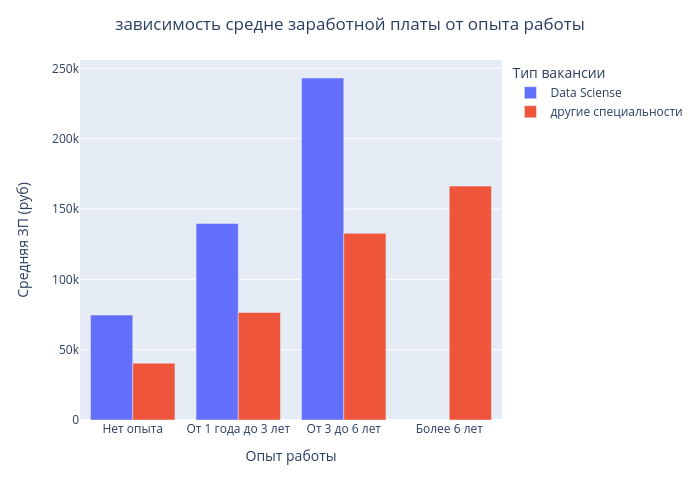

In [125]:
fig = px.bar(
    df_add_1,
    x="experience",
    y='mean_salary',
    color='vacansies_type',
    barmode='group',
)
fig.update_layout(
    title={
        'text': 'зависимость средне заработной платы от опыта работы',
        'x': 0.5,
    },
    yaxis=dict(
        title={
            'text': 'Средняя ЗП (руб)'
        },        
    ),
    xaxis=dict(
        title={
            'text': 'Опыт работы'
        },        
    ),
    legend=dict(
        title={
            'text': 'Тип вакансии',
        }, 
    ),
)

fig.show('png')

Явно видно почти двукратное превышение среднего уровня ЗП для специальностей DS относительно всех остальных.   
Интересно, но было бы гораздо интереснее разбить другие специальности на категории и посмотреть более предметно.  
Кроме того нет ЗП для DS с опытом более 6 лет.

In [126]:
# проверим, есть ли вакансии DS с опытом работы более 6 лет
query_add_2 = f'''
	SELECT			
		v.experience,
		COUNT(v.id)
	FROM vacancies v
	WHERE
		{ds_only} -- фильтр исключающий DS 
	GROUP BY v.experience
'''

In [127]:
# результат запроса
df_add_2  = pd.read_sql_query(query_add_2, connection)
df_add_2 

,experience,count
0,Более 6 лет,34
1,Нет опыта,28
2,От 1 года до 3 лет,223
3,От 3 до 6 лет,195


Итого 34 DS вакансии с опытом работы более 6 лет, но ни для одной не указана зарплатная вилка.  

За еду работают?  
Военная тайна?  

In [128]:
# какие навыки востребованы в DS кроме Python и SQL?
query_add_3 = f'''
    SELECT
        -- разделим строку с ключевыми навыками по символу табуляции chr(9) 
        -- функция разбивают строку в таблицу
        REGEXP_SPLIT_TO_TABLE(ds.key_skills, chr(9)) skills,
        COUNT(*),
        -- посчитаем процент количества каждого из навыков
        ROUND(COUNT(*) * 100.0 / COUNT(COUNT(*)) OVER(),2) percent
    FROM (
        SELECT *
        FROM public.vacancies as v
        WHERE {ds_only} -- фильтр по DS
        ) ds
    GROUP BY skills
    ORDER BY count DESC
    LIMIT 20
''' 

In [129]:
# результат запроса
df_add_3  = pd.read_sql_query(query_add_3, connection)
df_add_3

,skills,count,percent
0,Python,348,82.46
1,SQL,191,45.26
2,Machine Learning,114,27.01
3,Git,66,15.64
4,Математическая статистика,62,14.69
5,Data Analysis,54,12.80
6,Data Science,52,12.32
7,Pandas,52,12.32
8,ML,49,11.61
9,Английский язык,48,11.37


В тройке лидеров по востребованности навыков Python, SQL и Machine Learning.  
Базовые вещи, без которых никуда!  
Первое, чем нужно овладеть, для входа в профессию. Остальное, судя по всему наслаивается на эти навыки.

In [130]:
# какая средняя ЗП в разрезе ключевых навыков.
query_add_4 = f'''
    SELECT
        -- разделим строку с ключевыми навыками по символу табуляции chr(9) 
        -- функция разбивают строку в таблицу
        DISTINCT REGEXP_SPLIT_TO_TABLE(ds.key_skills, chr(9)) skills,
        ROUND(
            AVG(COALESCE( -- расчёт ЗП, среднее про 2м колонкам или значение из колонки, если во второй NULL
                        (ds.salary_from + ds.salary_to) / 2, ds.salary_from, ds.salary_to, 0
                    )
        ) -- группировка оконной функции по полученной выше таблице навыков
        OVER(PARTITION BY REGEXP_SPLIT_TO_TABLE(ds.key_skills, chr(9))) 
            )::int as mean_salary
    FROM (
        SELECT *
        FROM public.vacancies as v
        WHERE {ds_only} -- фильтр по DS
        ) ds
    GROUP BY skills, ds.salary_from, ds.salary_to
    ORDER BY mean_salary DESC
    LIMIT 20    
'''

In [131]:
# результат запроса
df_add_4  = pd.read_sql_query(query_add_4, connection)
df_add_4 

,skills,mean_salary
0,HTTP,450000
1,computer vision,300000
2,Google Analytics,300000
3,алгоритмы,300000
4,Бизнес-аналитика,300000
5,Высокая степень ответственности,300000
6,Знание стека DS,300000
7,"Знание теории машинного обучения, теории вероя...",300000
8,Коммуникация,300000
9,Основы алгоритмов и структур данных,300000


Любопытный результат!   
Это лишь подтверждает догадку о базовости навыков Python, SQL и Machine Learning, поскольку эти позиции не входят в первую двадцатку по ЗП.  

Для более высокой ЗП требуются более глубокие знания, кроме того присутствует узкая специализация и "мягкие" навыки.

In [132]:
#  посмотрим соотношение вакансий DS и остальных в разрезе городов миллионников
query_add_5 = f'''
    WITH all_vac AS ( -- создаём таблицу all_vac со всеми вакансиями в городах миллионниках
        SELECT 
            a.name,
            COUNT(DISTINCT v.id) all_vacancies_count
        FROM 
            employers e
            LEFT JOIN vacancies v ON e.id = v.employer_id
            LEFT JOIN areas a ON v.area_id = a.id
        WHERE a.name IN {cities}
        GROUP BY a.name
        ORDER BY all_vacancies_count DESC
    ),
    ds_vac AS ( -- создаём таблицу ds_vac с ds вакансиями в городах миллионниках
        SELECT 
            a.name,
            COUNT(DISTINCT v.id) ds_vacancies_count
        FROM 
            employers e
            LEFT JOIN vacancies v ON e.id = v.employer_id
            LEFT JOIN areas a ON v.area_id = a.id
        WHERE a.name IN {cities} AND {ds_only}
        GROUP BY a.name
        ORDER BY ds_vacancies_count DESC
    ),
    joined_t AS ( --соединяем две эти таблицы вместе
        SELECT
            a.name,
            all_vacancies_count,
            ds_vacancies_count,
            ds_vacancies_count * 100 / all_vacancies_count AS percent_ds_from_all
        FROM
            all_vac AS a LEFT JOIN ds_vac AS ds ON a.name = ds.name
    )
    (  -- объединим полученную выше таблицу с суммой по колонкам количества какансий
        SELECT *
        FROM joined_t
    )
    UNION ALL
    (
        SELECT 
            'Total' AS name,
            SUM(all_vacancies_count) all_vacancies_count,
            SUM(ds_vacancies_count) ds_vacancies_count, 
            NULL
        FROM joined_t
    )    
'''

In [133]:
# результат запроса
df_add_5  = pd.read_sql_query(query_add_5, connection)
df_add_5 

,name,all_vacancies_count,ds_vacancies_count,percent_ds_from_all
0,Москва,5333.0,217.0,4.0
1,Санкт-Петербург,2851.0,64.0,2.0
2,Новосибирск,2006.0,23.0,1.0
3,Екатеринбург,1698.0,7.0,0.0
4,Нижний Новгород,1670.0,20.0,1.0
5,Казань,1415.0,16.0,1.0
6,Краснодар,1301.0,6.0,0.0
7,Самара,1144.0,5.0,0.0
8,Ростов-на-Дону,1131.0,6.0,0.0
9,Воронеж,1063.0,2.0,0.0


Как и следовало ожидать, в столице самое большое количество вакансий, там-же больше всего вакансий DS.  
Любопытно, что в РФ только у 5 городов миллионников процент вакансий DS больше либо равен 1.  
Наблюдается низкий спрос на специалистов данного профиля в таких промышленных центрах, как Екатеринбург и Челябинск.  
Похоже, что на момент формирования БД, относительно новые методики, которые предоставляет DS, еще не были восприняты производством.